# Lab 04: Extracting topics from research articles

# Part I: Data preprocessing

### Load dataset

- Source: https://www.kaggle.com/blessondensil294/topic-modeling-for-research-articles/version/1
- Download: https://georgetown.box.com/s/1qkrvdewe8ez35f2asblxysh136dvh6b

In [3]:
import pandas as pd

train_data = pd.read_csv('train.csv').sample(frac=1)
test_data = pd.read_csv('test.csv').sample(frac=1)

In [4]:
train_data

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
5974,5975,Chaotic zones around rotating small bodies,"Small bodies of the Solar system, like aster...",0,1,0,0,0,0
20170,20171,"Uniformizations of stable $(γ,n)$-gonal Rieman...","A $(\gamma,n)$-gonal pair is a pair $(S,f)$,...",0,0,1,0,0,0
2447,2448,Scaling the Scattering Transform: Deep Hybrid ...,We use the scattering network as a generic a...,1,0,0,0,0,0
12083,12084,Sharing Means Renting?: An Entire-marketplace ...,"Airbnb, an online marketplace for accommodat...",1,1,0,0,0,0
2328,2329,Min-Max Regret Scheduling To Minimize the Tota...,We study the single machine scheduling probl...,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
19106,19107,Hybrid Dirac Semimetal in CaAgBi Materials Family,"Based on their formation mechanisms, Dirac p...",0,1,0,0,0,0
10728,10729,A Theoretical Analysis of Sparse Recovery Stab...,Dantzig selector (DS) and LASSO problems hav...,0,0,1,1,0,0
16989,16990,Forecasting Crime with Deep Learning,The objective of this work is to take advant...,0,0,0,1,0,0
12484,12485,A new generator of chaotic bit sequences with ...,This paper presents a new generator of chaot...,0,1,0,0,0,0


In [5]:
for topic in train_data.columns[3:]:
    print(f"{topic}: {sum(train_data[topic]) / len(train_data):.3f}")

Computer Science: 0.410
Physics: 0.287
Mathematics: 0.268
Statistics: 0.248
Quantitative Biology: 0.028
Quantitative Finance: 0.012


### Reuse Spacy pipeline from Lab-02 for text normalization & preprocessing

In [89]:
import re
import spacy
from spacy.language import Language

M = 2500

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " "),                   # Stips extra whitespace
    (r"\W", " ")
]

train_sentences = []
for i, d in enumerate(train_data['ABSTRACT'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    train_sentences.append(d)


@Language.component("lab04Preprocessor")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("lab04Preprocessor")

<function __main__.ng20_preprocess(doc)>

### Pass data through our Spacy pipeline

In [90]:
docs = []
for sent in train_sentences[:M]:
    docs.append(pipeline(sent))

### Compute number of unique words (vocabulary size)

In [78]:
vocab_size = len(set(" ".join(docs).split(" ")))
vocab_size

17200

# Part 2: Build Features

### Build the term-document matrix (i.e., BOW features)

In [91]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
bow_featurizer = CountVectorizer(max_features=vocab_size, max_df=0.95, min_df=0.005, stop_words='english')
tfidf_featurizer = TfidfVectorizer(max_features=vocab_size, max_df=0.95, stop_words='english')
X_bow = bow_featurizer.fit_transform(docs)
X_tfidf = tfidf_featurizer.fit_transform(docs)
type(X_bow), X_bow.shape

(scipy.sparse.csr.csr_matrix, (2500, 1986))

### Create a index-to-word map

In [92]:
idx2word = {idx: word for word, idx in bow_featurizer.vocabulary_.items()}

### Number of topics hyperparameter

In [93]:
# Configurable
K = 10

### Plotting subroutine to visualize words

In [94]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def plot_top_words(model, feature_names, n_top_words, title):
    plt.clf()
    cols = 5
    rows = K // 5 + K % 5
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[::-1][:n_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### (10 pts) Task I: Build a LSA model

In this task we are going to build a LSA topic model from scratch. From lecture-04, we learned about LSA from the perspective of document retrieval. For document retrieval, you'll recall that we computed a truncated SVD by choosing some number of dimension $K << N$. This gave us the left singular column vectors, $\mathbf{V} \in \mathbb{R}^{N \times K}$, and the diagonal singular value matrix, $\boldsymbol{\Sigma} \in \mathbb{R}^{K \times K}$ that we needed in order to project our queries, $\mathbf{q} \in \mathbb{R}^{N}$, and documents, $\mathbf{d} \in \mathbb{R}^{N}$, into $\mathbb{R}^{K}$ space. Recall that the operation to do that was:

$$\hat{\mathbf{q}} = \mathbf{q}\mathbf{V}\mathbf{\Sigma}^{-1} $$

In this task, we're going to evaluate the singular values, $\sigma_{i,j}$ in $\mathbf{\Sigma}$, and their corresponding basis vectors, $\mathbf{u}^{(j)}$, in $\mathbf{U}$, to extract the principal themes in the data. Execute the following subtasks.

1. For each column vector, print out the top 10 most relevant words.
2. Visualize the top 10 words using the `plot_topics()` function provided above.
3. What affect does the hyperparameter $K$ have on the result?
4. Is there a principled way to determine an appropriate value for $K$?

In [95]:
from sklearn.decomposition import TruncatedSVD
import pandas as pd
svd_model = TruncatedSVD(n_components=K, algorithm='randomized',n_iter=10)
svd_matrix= svd_model.fit_transform((X_tfidf))
dictionary= tfidf_featurizer.get_feature_names()
encoding_matrix = pd.DataFrame(svd_model.components_, columns = (dictionary)).T
def top10_relevant(matrix):
  rlvnt_words= list()
  for i in range(K):
    ind= matrix.iloc[:,i].argsort()[::-1][:10]
    top_features = [dictionary[i] for i in ind]
    rlvnt_words.append(top_features)
  rlvnt_words= pd.DataFrame(rlvnt_words, index=['topic'+ str(i) for i in range(K)])
  return rlvnt_words.T
top10_relevant(encoding_matrix)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,number,number,number,phase,network,model,network,graph,model,user
1,model,mathbb,network,model,group,estimator,function,group,graph,social
2,method,star,neural,field,algebra,datum,neural,algorithm,equation,group
3,network,mass,learn,quantum,mathbb,distribution,node,node,time,robot
4,datum,galaxy,task,magnetic,neural,group,estimator,edge,learn,control
5,problem,mathrm,image,spin,representation,sample,model,sample,solution,equation
6,algorithm,temperature,deep,temperature,graph,latent,graph,social,mathcal,solution
7,propose,rm,datum,energy,space,estimation,distribution,measure,task,design
8,time,magnetic,learning,interaction,mathcal,estimate,equation,user,latent,information
9,result,delta,dataset,effect,task,parameter,estimate,matrix,problem,test


<Figure size 432x288 with 0 Axes>

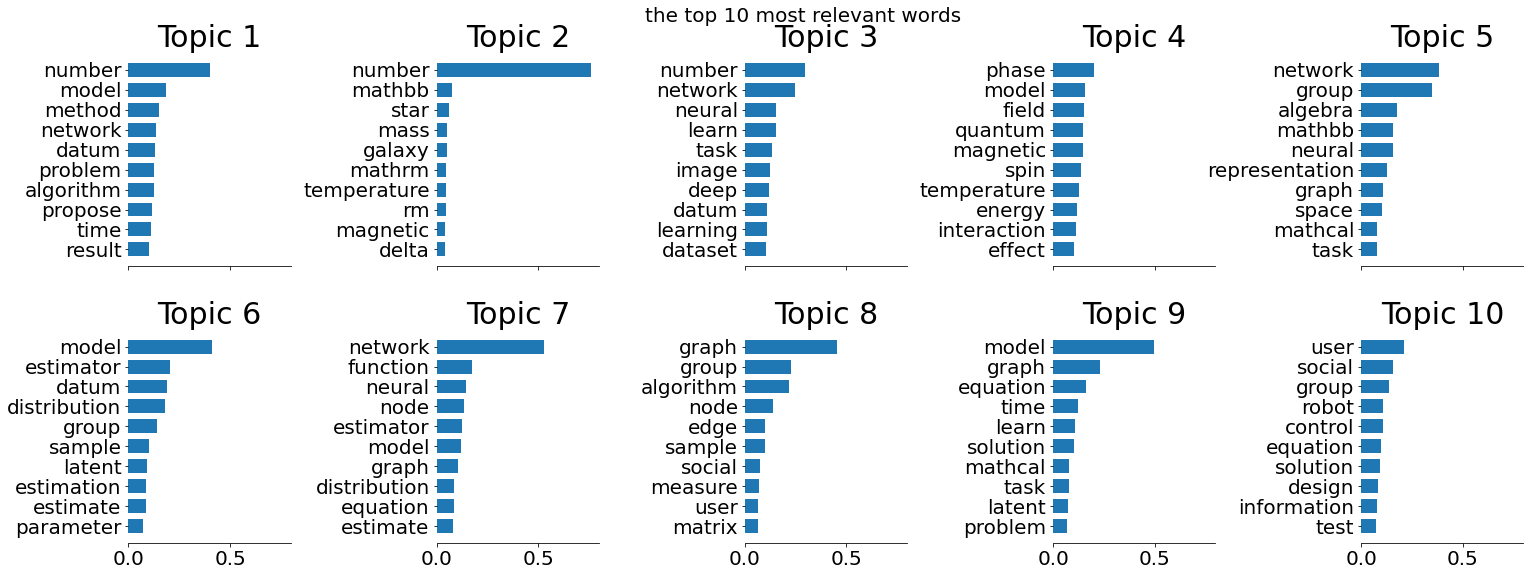

In [96]:
plot_top_words(svd_model, dictionary, 10, "the top 10 most relevant words")

### (5 pts) Task 2: Perform topic extraction using the NMF and LDA models from sklearn

In this task we perform topic extraction using the Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) models provided by sklearn. 

1. Fit the NMF and LDA models in the provided cells below.
2. Visualize the results using the `plot_topics` function.
3. How do the results compare to your home-spun LSA topic model?
4. What are the differences between these model that might give rise to these results?

In [97]:
from sklearn.decomposition import NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
NMF_model = NMF(n_components=K, init='random', random_state=10)
NMF_matrix  = NMF_model.fit_transform(X_tfidf)
encoding_matrix = pd.DataFrame(NMF_model.components_, columns = (dictionary)).T
def top10_relevant(matrix):
  rlvnt_words= list()
  for i in range(K):
    ind= matrix.iloc[:,i].argsort()[::-1][:10]
    top_features = [dictionary[i] for i in ind]
    rlvnt_words.append(top_features)
  rlvnt_words= pd.DataFrame(rlvnt_words, index=['topic'+ str(i) for i in range(K)])
  return rlvnt_words.T
top10_relevant(encoding_matrix)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,model,phase,group,image,learn,algorithm,function,number,network,equation
1,estimator,field,algebra,method,task,problem,mathbb,star,neural,solution
2,datum,quantum,finite,robot,learning,method,space,cluster,node,nonlinear
3,distribution,magnetic,graph,object,datum,optimization,operator,mass,social,differential
4,parameter,spin,subgroup,numberd,machine,graph,inequality,galaxy,community,boundary
5,sample,temperature,representation,sensor,dataset,matrix,mathcal,rm,layer,flow
6,method,state,abelian,gan,deep,solve,prove,delta,information,problem
7,estimation,energy,lie,imaging,training,optimal,manifold,mathrm,graph,time
8,estimate,transition,module,adversarial,representation,propose,result,time,deep,existence
9,propose,interaction,prove,propose,label,time,set,log,training,soliton


In [106]:
from gensim.models import ldamodel
import gensim.corpora
doc_= [line.split() for line in docs]
id2word = gensim.corpora.Dictionary(doc_)
corpus = [id2word.doc2bow(text) for text in doc_]
lda = ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=K)
def get_lda_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10)
        word_dict['Topic ' + '{:02d}'.format(i)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)
get_lda_topics(lda, K)

,Topic 00,Topic 01,Topic 02,Topic 03,Topic 04,Topic 05,Topic 06,Topic 07,Topic 08,Topic 09
0,model,model,number,number,number,network,number,number,number,number
1,base,number,system,result,network,method,n,datum,result,network
2,method,time,model,state,problem,number,problem,model,model,social
3,system,result,time,system,datum,propose,graph,x,method,method
4,propose,method,propose,model,algorithm,neural,algorithm,n,equation,paper
5,result,datum,base,cell,function,deep,k,method,high,user
6,network,paper,result,control,paper,model,result,magnetic,system,model
7,present,problem,method,phase,model,learn,r,result,estimate,ell
8,field,system,network,field,approach,task,set,find,study,datum
9,learn,function,study,magnetic,propose,datum,method,star,order,result


<Figure size 432x288 with 0 Axes>

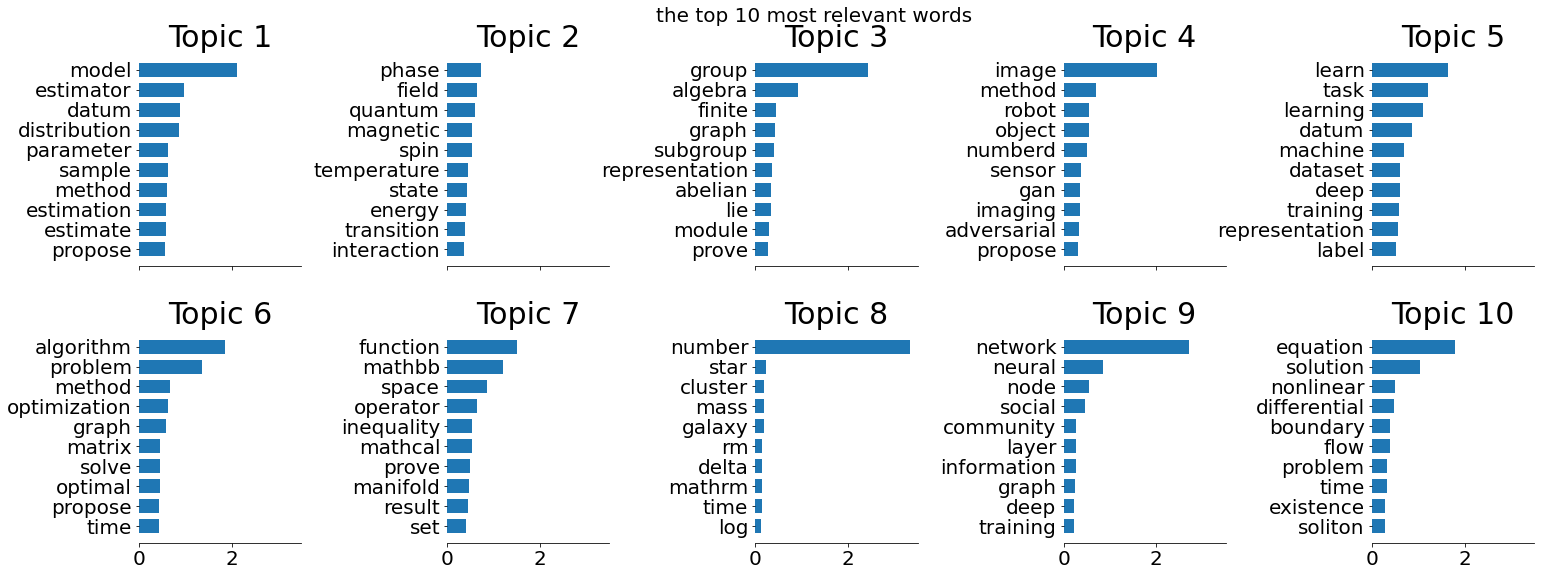

AttributeError: module 'pyLDAvis' has no attribute 'gensim'

In [111]:
plot_top_words(NMF_model, dictionary, 10, "the top 10 most relevant words")

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
lda_display = pyLDAvis.gensim.prepare(lda, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

### (5 pts) Task 3: Map the test data onto the topic spaces learned from the LSA, NMF, and LDA models

The purpose of this task is to assign topics to the test data

In [ ]:
test_sentences = []
for i, d in enumerate(test_data['ABSTRACT'][:50]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    test_sentences.append(d)
test_docs = []
for sent in train_sentences[:M]:
    test_docs.append(pipeline(sent))
test_bow = bow_featurizer.fit_transform(test_docs)
test_tfidf = tfidf_featurizer.fit_transform(test_docs)

#LSA
LSA_topic_pred= svd_model.fit_transform((test_tfidf))

#NMF
NMF_topic_pred= NMF_model.fit_transform(test_tfidf)
    
#LDA   
test_doc_= [line.split() for line in test_docs_]    
id2word = gensim.corpora.Dictionary(test_docs_)
corpus = [id2word.doc2bow(text) for text in test_docs_]
LDA_topic_pred= lda.get_document_topics(corpus)